In [2]:

import tensorflow as tf
from tensorflow.keras.models import Model
import tensorflow as tf
#import tensorflow.keras.layers.BatchNormalization
from tensorflow.keras.optimizers import SGD
import os
import pandas as pd
import numpy as np
from tensorflow.keras import backend as k
import matplotlib.pyplot as plt
import cv2
import tensorflow.keras.layers as k
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from scipy import ndimage
import scipy
import itertools
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras import backend as K
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from skimage.feature import hog
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import  MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
#from tensorflow.keras.callbacks import TensorBoard

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
def calculateClass(img,n_labels):
    h=256
    w=256
    lab=np.zeros([h,w])
    for i in range (h):
        for j in range (w):
            b=img[i][j][0]
            g=img[i][j][1]
            r=img[i][j][2]
            if b==0 and g==0 and r==0:
                lab[i][j]=0
            else:
                lab[i][j]=1
    return lab

In [4]:
def create_label(img, dims, n_labels=2):
    labels=calculateClass(img,n_labels)
    x1 = np.zeros([dims[0], dims[1], n_labels])
    for i in range(dims[0]):
        for j in range(dims[1]):
            v1=int(labels[i][j])
            x1[i][j][v1]=1
    x1 = x1.reshape(dims[0] , dims[1], n_labels)
    return x1

In [5]:
def Prepare_data(path_train,path_gt, n_labels):
    imgs = []
    labels= []
    files_train = os.listdir(path_train)
    files_gt = os.listdir(path_gt)
    for i in range(len(files_train)):
             if(i!=0):
                original_img = cv2.imread(path_train + "/" + files_train[i])
                if original_img is None:
                      print('Wrong path:', path_train + "/" + files_train[i])
                      continue
                resized_img = cv2.resize(original_img, (256,256))
                array_img = img_to_array(resized_img)/255
                imgs.append(array_img)
            # masks
                mask = cv2.imread(path_gt+ "/" +files_gt[i])
                if mask is None:
                      print('Wrong path:', path_gt+ "/" +files_gt[i])
                mask = cv2.resize(mask , (256,256))
                array_mask = create_label(mask, (256,256), 2)
                labels.append(array_mask )
    imgs = np.array(imgs)
    labels= np.array(labels)
    return imgs, labels

In [6]:
def Calculate_metrics(test_image, gt,test_data):
    size=len(test_image)
    h,w,b1=np.shape(test_image[0])

    y_pred=np.zeros((h*w*size,1))
    y_test=np.zeros((h*w*size,1))

    res_img=[]

    for q in range (size):
        img11=test_image[q]
        img=np.zeros((256,256,3))
        for i in range (h):
            for j in range (w):
                c1=img11[i][j][0]
                c2=img11[i][j][1]

                if c1>c2:
                    img[i][j]=[0,0,0]
                else:
                    img[i][j]=[255,255,255]

        res_img.append(img)


    res_img = np.array(res_img)
    c=0


    #calculate ypred for all test images
    for i in range (size):
        img=res_img[i]
        for j in range (h):
            for l in range (w):
                b=img[j][l][0]
                g=img[j][l][1]
                r=img[j][l][2]
                if r==0 and g==0 and b==0:
                    y_pred[c][0]=0
                else:
                    y_pred[c][0]=1
                c=c+1
    c=0
    for i in range (size):
        img=gt[i]
        for j in range (h):
            for l in range (w):
                b=img[j][l][0]
                if b==0:
                    y_test[c][0]=0
                else:
                    y_test[c][0]=1
                c=c+1


    print(classification_report(y_test, y_pred))
    return

In [7]:
def Unet(pretrained_weights = None,input_size = (256,256,3)):

    inputs = tf.keras.Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1=tf.keras.layers.BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1=tf.keras.layers.BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2=tf.keras.layers.BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2=tf.keras.layers.BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3=tf.keras.layers.BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3=tf.keras.layers.BatchNormalization(name='b1')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4=tf.keras.layers.BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4=tf.keras.layers.BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5=tf.keras.layers.BatchNormalization()(conv5)
    drop5 = k.Dropout(0.6)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = tf.keras.layers.concatenate([conv4,up6],  axis = -1)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6=tf.keras.layers.BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6=tf.keras.layers.BatchNormalization()(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = tf.keras.layers.concatenate([conv3,up7],axis = -1)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7=tf.keras.layers.BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7=tf.keras.layers.BatchNormalization()(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = tf.keras.layers.concatenate([conv2,up8],axis = -1)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8=tf.keras.layers.BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8=tf.keras.layers.BatchNormalization()(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = tf.keras.layers.concatenate([conv1,up9], axis = -1)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9=tf.keras.layers.BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9=tf.keras.layers.BatchNormalization()(conv9)

    conv10 = Conv2D(2, 1, activation = 'softmax')(conv9)
    model = Model(inputs = [inputs], outputs = [conv10])
    model.compile(optimizer=Adam(lr=0.00001), loss ='categorical_crossentropy'  ,  metrics = ['accuracy']) #'categorical_crossentropy'       dice_coef_loss

    model.summary()

    if(pretrained_weights):
      model.load_weights(pretrained_weights)
    return model

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_46 (Conv2D)             (None, 256, 256, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_32 (BatchN  (None, 256, 256, 64  256        ['conv2d_46[0][0]']              
 ormalization)                  )                                                           

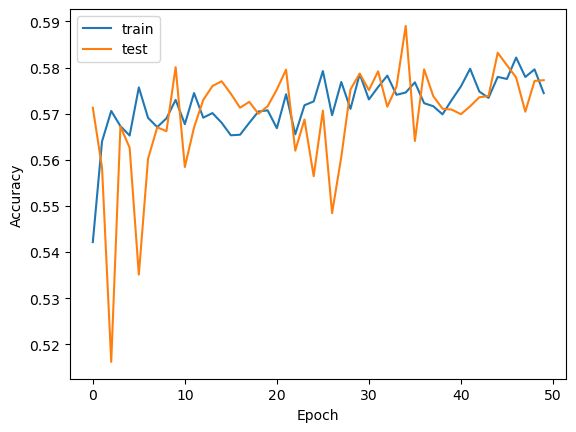

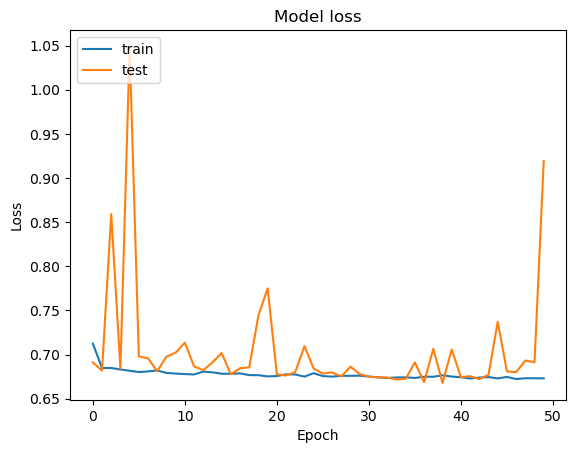

In [11]:
if __name__ == "__main__":
    path_train='/kaggle/input/dataset-aerial-image-segmentation/Image'
    path_gt='/kaggle/input/dataset-aerial-image-segmentation/Mask'

    nb_epoch =50
    batch = 1
    n_labels=2
    model=Unet().14
    *

    print("Preparing and loading training data...")
    train_data,gt = Prepare_data(path_train,path_gt,n_labels)


    print("Done Preparing training data...")


    print ('Model Compiled: OK.....')
    print("Opening model...")

    history=model.fit(train_data,gt,batch_size=batch, epochs=nb_epoch, verbose=1,validation_split=0.2)
    print("Model Fitting done...")

    model.save_weights('U-Net_50.hdf5')
    model.load_weights('U-Net_50.hdf5')

    fig=plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])    # plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    fig.savefig("accuracy.png")
    # # summarize history for loss
    fig=plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    fig.savefig("loss.png")

In [12]:
    path_test='/kaggle/input/dataset-aerial-image-segmentation/Image test'
    path_test_gt='/kaggle/input/dataset-aerial-image-segmentation/Mask Test'
    print("Preparing testing data...")
    test_data,gt= Prepare_data(path_test,path_test_gt,n_labels)

    

    output = model.predict(test_data, verbose=1)
    Calculate_metrics(output,gt,test_data)
    for i in range (len(test_data)):
        Write_output_path="Results/output/Img_"+str(i)+".png"
        out=output[i]
        img=test_data[i]
        for j in range(256):
            for p in range(256):
                if out[j][p][0]>out[j][p][1]:
                    img[j][p]=[0,0,0]
                else:
                    img[j][p]=[255,255,255]
                
                
        cv2.imwrite(Write_output_path,img)

Preparing testing data...
2/2 [==============================] - 43s 19s/step
              precision    recall  f1-score   support

         0.0       0.38      0.90      0.53   1445718
         1.0       0.61      0.09      0.16   2355370

    accuracy                           0.40   3801088
   macro avg       0.49      0.50      0.35   3801088
weighted avg       0.52      0.40      0.30   3801088

